# Social Network Graph

In [ ]:
# Python Libs
import re
import csv
import os
import datetime
import pandas as pd
import numpy as np
import time

# plotting and math libs
from tqdm import tqdm
import matplotlib.pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json
from collections import Counter
from collections import defaultdict
import datetime as datetime

import fasttext
import fasttext.util

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import networkx as nx

C:\Users\USER\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## User to User Graph

In this section we will create social graph that demonstrate the relationships between political users. each node represents a twitter user, each edge represents a link between 2 users if user1 has retweeted user2 and the weight is the amount of retweets of this tweet.
Since can be many retweets from user1 of user2 we allocated the max among them.


In [ ]:
# loading the data
users_tweets_path_r = 'F:\\SocialDynamics\\TrendsProject\\Tweets\\Right_Users_Tweets.csv'
users_tweets_path_l = 'F:\\SocialDynamics\\TrendsProject\\Tweets\\Left_Users_Tweets.csv'
df_r = pd.read_csv(users_tweets_path_r)
df_l = pd.read_csv(users_tweets_path_l)
df = df_r.append(df_l, ignore_index=True)

In [ ]:
df = df.fillna("_na_")

In [ ]:
userNames = df['user_name'].unique().tolist()

In [ ]:
len(userNames)

442

In [ ]:
def create_u2u_edges():
    edges = []
    retweet_count_dict = {}
    for u_name in userNames:
        temp_df = df[df['user_name'] == u_name]

        # Gathering all users ids that the current user retweeted their tweets
        reply_to_usersIDs = temp_df['reply_to_user_id'].unique().tolist()
        reply_to_usersIDs.remove('_na_')
        for reply_id in reply_to_usersIDs:

            # Gathering the user name of the current user id that has been retweeted
            re_df = df[df['user_id'] == reply_id]
            re_u_list = re_df['user_name'].unique().tolist()

            if len(re_u_list) > 0 and re_u_list[0] != u_name:
                new_edge = (re_u_list[0], u_name)
                if new_edge not in edges:

                    # Gathering the tweets that has been retweeted by u_name of the user reply_id
                    retweet_df = temp_df[temp_df['reply_to_user_id'] == reply_id]
                    max_retweets = retweet_df['retweet_count '].max() 

                    edges.append(new_edge)
                    retweet_count_dict[new_edge] = max_retweets
    return edges, retweet_count_dict

In [ ]:
edges, retweet_count_dict = create_u2u_edges()
len(edges)

23877

In [ ]:
max(retweet_count_dict.values())

170

<b> Creating nodes attributes for our graph: </b>
 
 > political stance: 0 - right wing, 1 - left wing
 
 > followers count of a user(node)
 
 > statuses count of a user(node)

In [ ]:
def get_attributes_dicts():
    class_dict = {}
    followers_dict = {}
    statuses_count_dict = {}
    for u_name in userNames:
        u_df = df[df['user_name'] == u_name]
        
        political_stance = u_df['class'].unique().tolist()[0]
        class_dict[u_name] = int(political_stance)
        
        followers_count = u_df['user_followers_count'].unique().tolist()[0]
        followers_dict[u_name] = int(followers_count)
        
        statuses_count = u_df['user_statuses_count'].unique().tolist()[0]
        statuses_count_dict[u_name] = int(statuses_count)
        
    return class_dict, followers_dict, statuses_count_dict

In [ ]:
class_dict, followers_dict, statuses_count_dict = get_attributes_dicts()

In [ ]:
G = nx.Graph()
G.add_nodes_from(userNames)
G.add_edges_from(edges)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 442
Number of edges: 20235
Average degree:  91.5611


In [ ]:
nx.set_node_attributes(G, class_dict, 'political_stance')
nx.set_node_attributes(G, followers_dict, 'followers_count')
nx.set_node_attributes(G, statuses_count_dict, 'statuses_count')

In [ ]:
# adding edges weights to the graph
for edge in edges:
    G[edge[0]][edge[1]]['weight'] = retweet_count_dict[edge]

In [ ]:
# Saving the graph to present it on Gephi
nx.write_gexf(G, "F:\\SocialDynamics\\TrendsProject\\users_retweet_w8_attr3.gexf")

### Trends to Users network
In this section we will create a graph that represents the influence of users on a trends collected since 1/1/2021 till 1/07/2021.

Nodes will be users and trends and edges will represents a link between trend and user if a user has tweeted a trend in its timeline.

Weights of the edges will be divided into 2 section which will associated with a different graph.


> First Graph: Weights will be calculated has the max number of retweets between a user tweet and a trend that appears in that tweet.

> Second Graph: Weights will be calculated as the amount of times the user tweeted tweets with that trend.

Reading the trends file

In [ ]:
trends_text = []
with open("F:\\SocialDynamics\\TrendsProject\\trends.txt", 'r', encoding='utf8') as f:
    trends_text = f.read().splitlines()

In [ ]:
trends = []
for t in trends_text:
    t = t.split('\t')
    if len(t) < 3:
        trends.append(t[1])
    else:
        trends.append(t[2])

In [ ]:
Nodes = trends.copy() + userNames.copy()

<b> Creating nodes attributes for our graph: </b>
 
 > political stance: 0 - right wing, 1 - left wing
 
 > followers count of a user(node)
 
 > statuses count of a user(node)
 
 > average tweets length of a user(node)

In [ ]:
def get_t2u_attr_dicts():
    class_dict, followers_dict, statuses_count_dict = get_attributes_dicts()
    
    class_trends = {}
    for t in trends:
        class_trends[t] = 2
        
    class_nodes = class_dict.copy()
    class_nodes.update(class_trends)
    
    avg_tweets_len = {}
    for u_name in userNames:
        u_df = df[df['user_name'] == u_name]
        
        avg_len = u_df['text'].apply(lambda x: len(x)).mean()
        avg_tweets_len[u_name] = round(avg_len)
    
    return class_nodes, followers_dict, statuses_count_dict, avg_tweets_len

In [ ]:
class_nodes, followers_dict, statuses_count_dict, avg_tweets_len = get_t2u_attr_dicts()

In [ ]:
class_nodes[trends[0]]

2

In [ ]:
def create_t2u_edges():
    edges = []
    retweet_count_dict = {}
    trend_tweets_count = {}
    for u_name in userNames:
        temp_df = df[df['user_name'] == u_name]

        for t in trends:
            trends_user_df = temp_df[temp_df['text'].str.contains(t)]
            
            if len(trends_user_df) > 0:
                new_edge = (t, u_name)
                if new_edge not in edges:
                    
                    max_retweets = trends_user_df['retweet_count '].max()
                    if max_retweets > 45:
                        retweet_count_dict[new_edge] = max_retweets

                        trend_tweets_count[new_edge] = len(trends_user_df)

                        edges.append(new_edge)

    return edges, retweet_count_dict, trend_tweets_count

In [ ]:
edges_t2u, retweet_count_dict_t2u, trend_tweets_count = create_t2u_edges()

In [ ]:
G_T2U = nx.Graph()
G_T2U.add_nodes_from(Nodes)
G_T2U.add_edges_from(edges_t2u)
print(nx.info(G_T2U))

Name: 
Type: Graph
Number of nodes: 492
Number of edges: 1429
Average degree:   5.8089


In [ ]:
class_nodes, followers_dict, statuses_count_dict, avg_tweets_len
nx.set_node_attributes(G_T2U, class_nodes, 'political_stance')
nx.set_node_attributes(G_T2U, followers_dict, 'followers_count')
nx.set_node_attributes(G_T2U, statuses_count_dict, 'statuses_count')
nx.set_node_attributes(G_T2U, avg_tweets_len, 'avg_tweet_length')

In [ ]:
def update_edges_weights(g, edgs, w_dic):
    for edge in edgs:
        g[edge[0]][edge[1]]['weight'] = w_dic[edge]

Saving the graphs

Graph 1

In [ ]:
update_edges_weights(G_T2U, edges_t2u, retweet_count_dict_t2u)

In [ ]:
nx.write_gexf(G_T2U, "F:\\SocialDynamics\\TrendsProject\\tredns_2_users_RetweetsWeights.gexf")

Graph 2

In [ ]:
update_edges_weights(G_T2U, edges_t2u, trend_tweets_count)

In [ ]:
nx.write_gexf(G_T2U, "F:\\SocialDynamics\\TrendsProject\\tredns_2_users_TweetsCountWeights.gexf")

In [ ]:
len(class_dict), len(followers_dict), len(avg_tweets_len), len(statuses_count_dict)

(442, 442, 442, 442)

### Analyzing Info

Saving the metadata into a csv file

In [ ]:
columns = ['user_name', 'followers_count', 'avg_tweet_length', 'statuses_count', 'political_stance']
df = pd.DataFrame({'user_name': class_dict.keys(), 
                   'followers_count': followers_dict.values(), 
                   'avg_tweets_length': avg_tweets_len.values(), 
                   'statuses_count': statuses_count_dict.values(), 
                   'political_stance': class_dict.values()})

In [ ]:
df.to_csv("F:\\SocialDynamics\\TrendsProject\\Users_Tweets_Info.csv")

Helper functions

In [ ]:
def create_and_sort_by_col(df: pd.DataFrame, col: str):
    """
    Sorting values in an ascending order
    """
    df_0 = df[df['political_stance'] == 0]
    df_1 = df[df['political_stance'] == 1]
    
    df_0 = df_0.sort_values(by=col, ascending=False)
    df_1 = df_1.sort_values(by=col, ascending=False)
    
    return df_0, df_1

def plot_info(df_0: pd.DataFrame, df_1: pd.DataFrame, col: str, title: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(20,20))
    
    ax.plot([i for i in range(len(df_0))], df_0[col].tolist(), 'g', label="Right Wing")
    ax.plot([i for i in range(len(df_1))], df_1[col].tolist(), 'r', label="Left Wing")
    
    ax.set_xlabel('User Index', fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    
    ax.legend(fontsize=30)
    ax.set_title(title, fontsize=30)
    plt.savefig(f'F:\\SocialDynamics\\TrendsProject\\{title}.png')

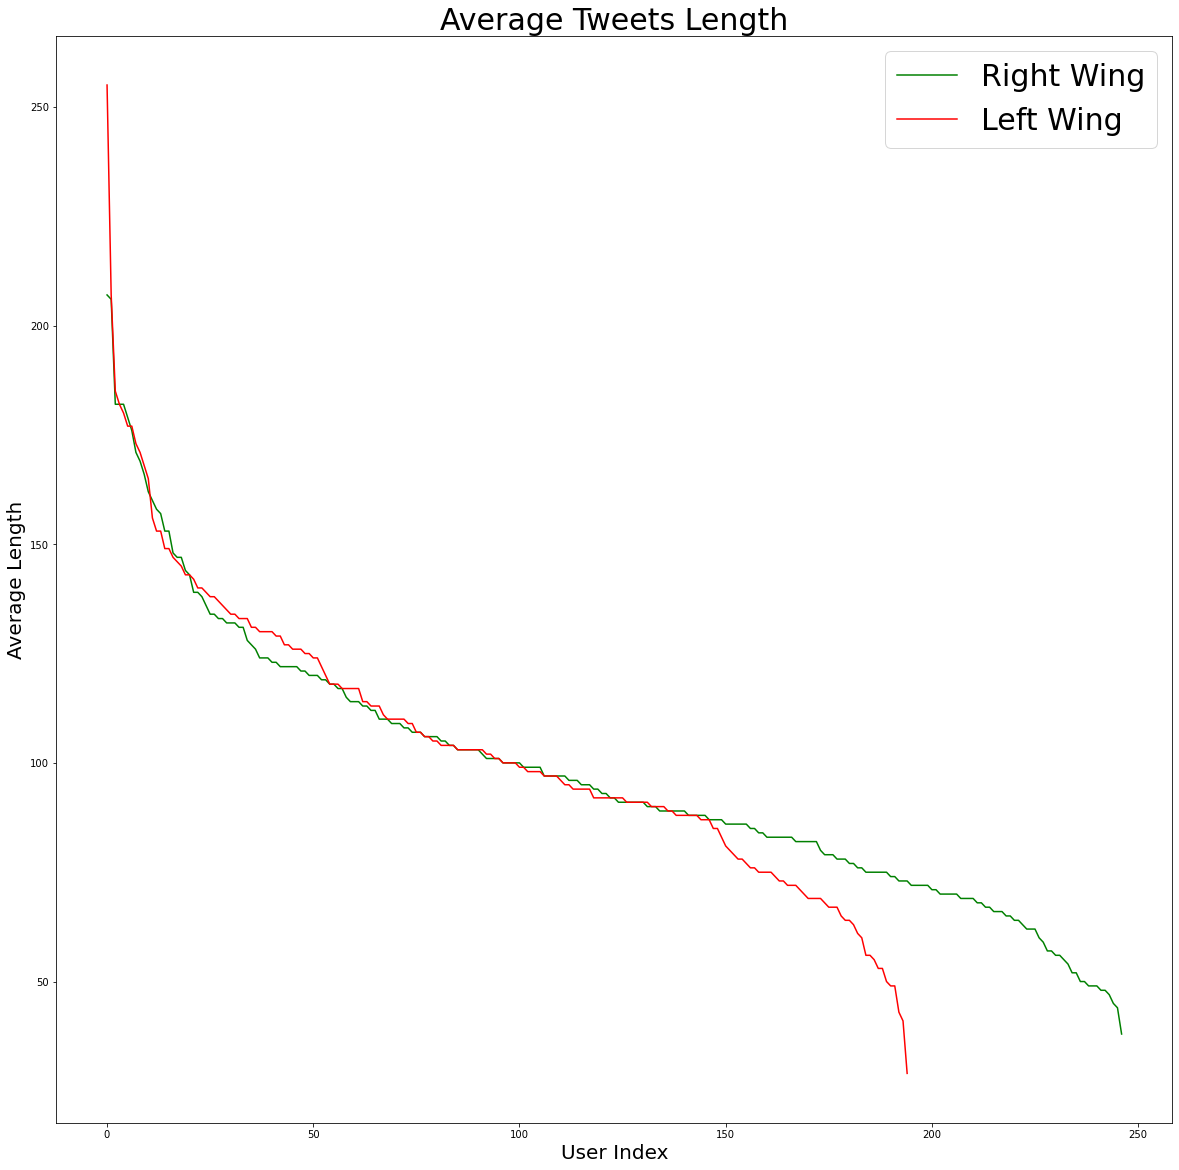

In [ ]:
df_0, df_1 = create_and_sort_by_col(df, 'avg_tweets_length')
plot_info(df_0, df_1, 'avg_tweets_length', "Average Tweets Length", "Average Length")

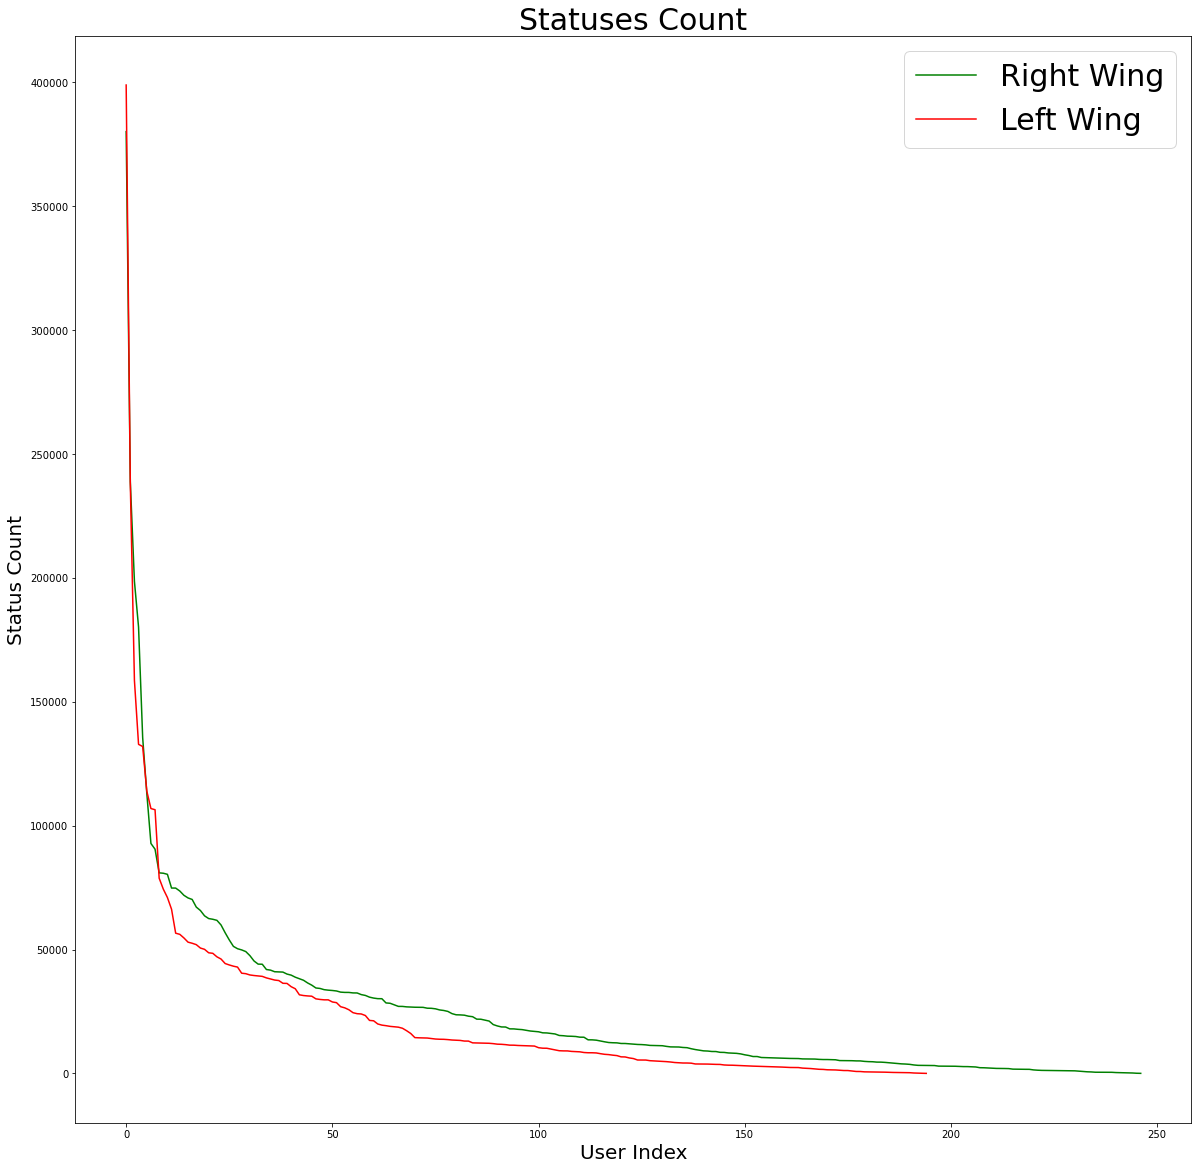

In [ ]:
df_0, df_1 = create_and_sort_by_col(df, 'statuses_count')
plot_info(df_0, df_1, 'statuses_count', "Statuses Count", "Status Count")

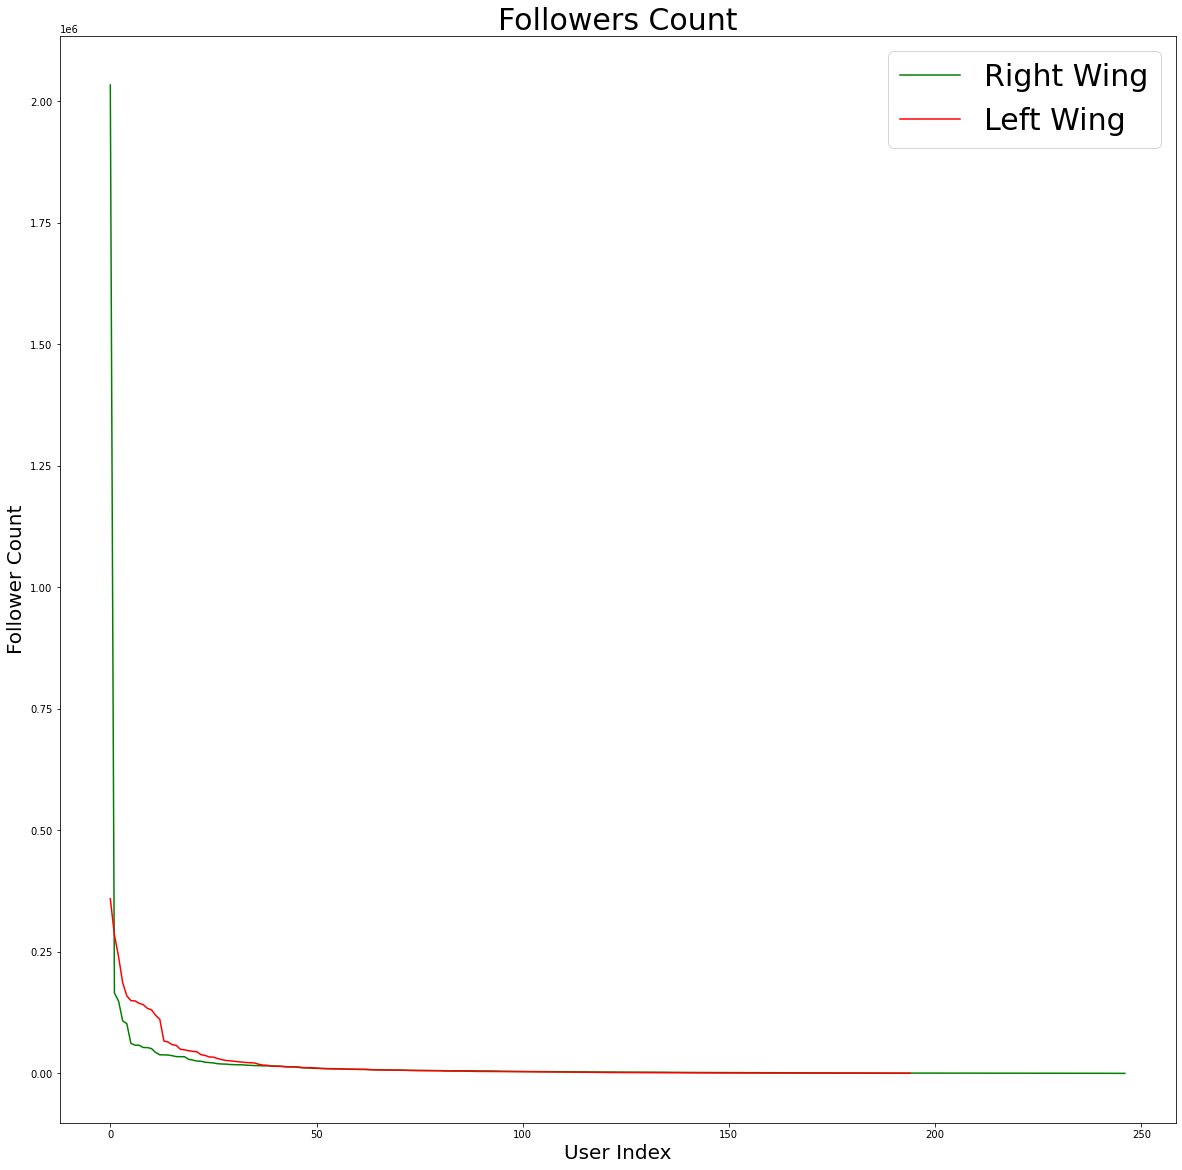

In [ ]:
df_0, df_1 = create_and_sort_by_col(df, 'followers_count')
plot_info(df_0, df_1, 'followers_count', "Followers Count", "Follower Count")

<b> Analyzing the political stance of each trend by retweet counts  </b>

In [ ]:
influencers_dict = {}
for t in trends:
    influencers_dict[t] = {'0': 0, '1': 0}
    
for t in trends:
    for key in retweet_count_dict_t2u.keys():
        if t in key[0]:
            if class_nodes[key[1]] == 0:
                influencers_dict[t]['0'] += retweet_count_dict_t2u[key]
            else:
                influencers_dict[t]['1'] += retweet_count_dict_t2u[key]

In [ ]:
right_inf_dict = [x['0'] for x in influencers_dict.values()]
left_inf_dict = [x['1'] for x in influencers_dict.values()]

In [ ]:
inf_df = pd.DataFrame({'Trends': trends, 'Right': right_inf_dict, 'Left': left_inf_dict})

In [ ]:
inf_df

,Trends,Right,Left
0,שאשא פאקה,0,0
1,חוק צרפתי,0,482
2,של שרה,698,884
3,עם שרה,0,0
4,רק ביבי,898,1029
5,חוזרים_לחיים,0,0
6,כחול לבן,2264,1935
7,רק נתניהו,127,99
8,רק מחל,1410,0
9,בן גביר,6258,12861


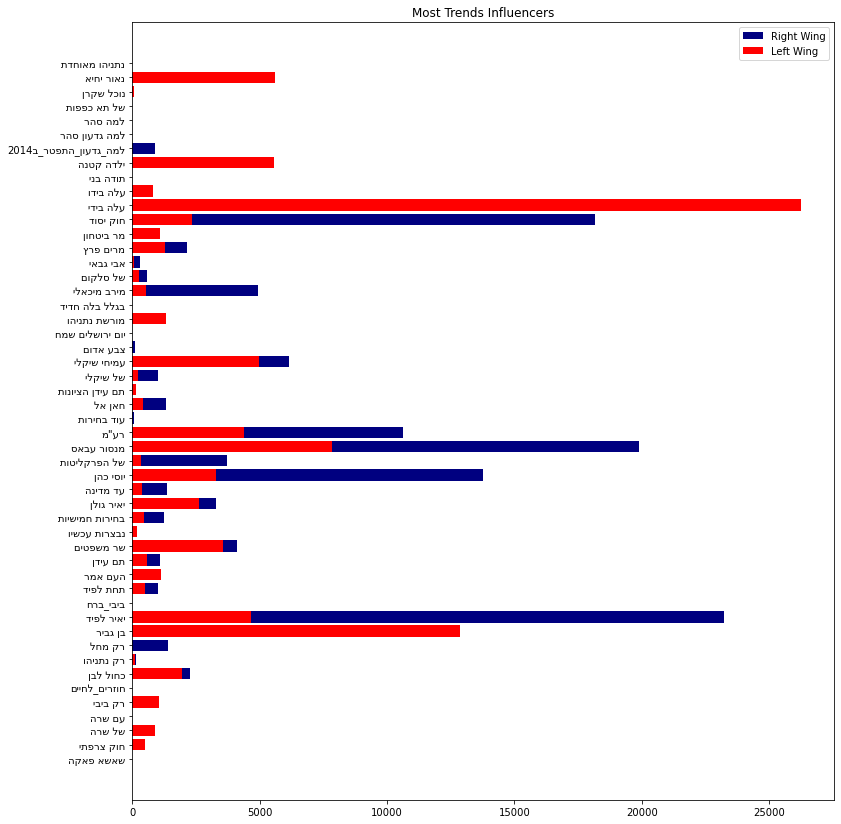

In [ ]:
from bidi import algorithm as bidialg
h_trends = [bidialg.get_display(x) for x in trends]
plt.figure(figsize=(15, 12))
plt.title("Most Trends Influencers")
plt.barh(h_trends, right_inf_dict, .8, label='Right Wing', color='navy')
plt.barh(h_trends, left_inf_dict, .8, label='Left Wing', color='red')
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)